In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from for_importing import X_cleaned
from binning_to_import import y_bins
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [2]:
###TWO FEATURES UNBALANCED
X=X_cleaned
y=y_bins['cluster'].to_numpy()

# Load example dataset
x2=X[['racepctblack', 'racePctWhite', 'pctWInvInc', 'pctWPubAsst',
       'PctPopUnderPov', 'TotalPctDiv', 'PctKids2Par', 'PctPersOwnOccup']].to_numpy()



# Split into training and testing
x2tr, x2ts, ytr, yts = train_test_split(X, y, test_size=0.2, random_state=22)



# Create and fit the model
model = LogisticRegression(max_iter=1000,solver='liblinear')
model.fit(x2tr, ytr)

# Predict and evaluate
y_pred = model.predict(x2ts)

print(classification_report(yts, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.98      0.93       317
           1       0.87      0.55      0.67        82

    accuracy                           0.89       399
   macro avg       0.88      0.76      0.80       399
weighted avg       0.89      0.89      0.88       399



Here, we see the effects of the class imbalance. The class 1 data is not being predicted with great accuracy. Need to implement class balancing.

In [3]:


# Create and fit the model


classes = np.array(['0', '1'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=ytr)


class_weight_dict = dict(zip(classes, weights))

# Then use in model
model = LogisticRegression(class_weight=class_weight_dict, max_iter=1000,solver='liblinear')

model.fit(x2tr, ytr)

# Predict and evaluate
y_pred = model.predict(x2ts)

print(classification_report(yts, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.87      0.91       317
           1       0.62      0.82      0.71        82

    accuracy                           0.86       399
   macro avg       0.78      0.84      0.81       399
weighted avg       0.88      0.86      0.87       399



balanced and Cross validated C

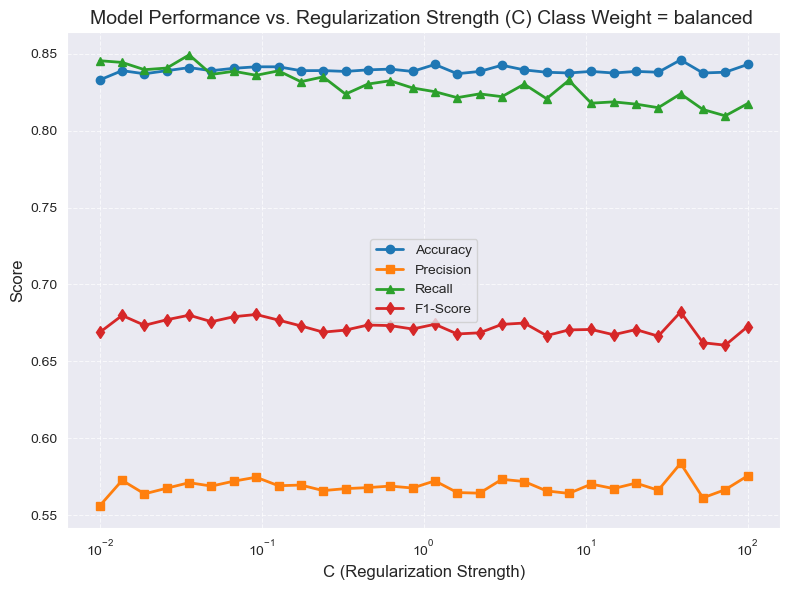

In [4]:

# Define C values to test
C_values = np.logspace(-2,2,30)
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)

# Store results for each C
results = {C: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for C in C_values}
X=X.to_numpy()

for C in C_values:
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LogisticRegression(C=C, solver='liblinear', max_iter=1000,class_weight='balanced')
        model.fit(X_train, y_train.astype(int))
        y_pred = model.predict(X_test)

        # Store metrics
        results[C]['accuracy'].append(accuracy_score(y_test.astype(int), y_pred.astype(int)))
        results[C]['precision'].append(precision_score(y_test.astype(int), y_pred.astype(int), pos_label=1,zero_division=0))
        results[C]['recall'].append(recall_score(y_test.astype(int), y_pred.astype(int), pos_label=1))
        results[C]['f1'].append(f1_score(y_test.astype(int), y_pred.astype(int), pos_label=1))

        # Compute mean metrics for each C
mean_accuracy = [np.mean(results[C]['accuracy']) for C in C_values]
mean_precision = [np.mean(results[C]['precision']) for C in C_values]
mean_recall = [np.mean(results[C]['recall']) for C in C_values]
mean_f1 = [np.mean(results[C]['f1']) for C in C_values]

# Plot settings
plt.figure(figsize=(8, 6))
plt.xscale('log')  # Log-scale for C (since C_values are log-spaced)

# Plot all metrics
plt.plot(C_values, mean_accuracy, marker='o', label='Accuracy', linewidth=2)
plt.plot(C_values, mean_precision, marker='s', label='Precision', linewidth=2)
plt.plot(C_values, mean_recall, marker='^', label='Recall', linewidth=2)
plt.plot(C_values, mean_f1, marker='d', label='F1-Score', linewidth=2)

# Labels and titles
plt.xlabel('C (Regularization Strength)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs. Regularization Strength (C) Class Weight = balanced ', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Using class weight=balanced (about 4:1), precision and F-1 score are consistently low. Instead, we need to use a lower class 1 weight for logistic regression, of 2:1.

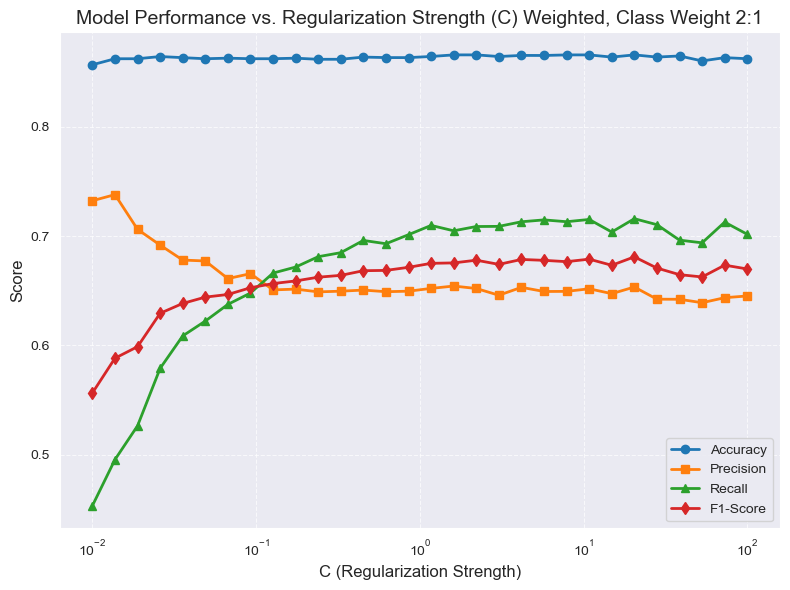

In [5]:

# Define C values to test
C_values = np.logspace(-2,2,30)
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)

# Store results for each C
results = {C: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for C in C_values}

for C in C_values:
    for train_index, test_index in kf.split(x2):
        X_train, X_test = x2[train_index], x2[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LogisticRegression(C=C, solver='liblinear', max_iter=1000,class_weight={0:1,1:2})
        model.fit(X_train, y_train.astype(int))
        y_pred = model.predict(X_test)

        # Store metrics
        results[C]['accuracy'].append(accuracy_score(y_test.astype(int), y_pred.astype(int)))
        results[C]['precision'].append(precision_score(y_test.astype(int), y_pred.astype(int), pos_label=1,zero_division=0))
        results[C]['recall'].append(recall_score(y_test.astype(int), y_pred.astype(int), pos_label=1))
        results[C]['f1'].append(f1_score(y_test.astype(int), y_pred.astype(int), pos_label=1))




# Compute mean metrics for each C
mean_accuracy = [np.mean(results[C]['accuracy']) for C in C_values]
mean_precision = [np.mean(results[C]['precision']) for C in C_values]
mean_recall = [np.mean(results[C]['recall']) for C in C_values]
mean_f1 = [np.mean(results[C]['f1']) for C in C_values]


# Plot settings
plt.figure(figsize=(8, 6))
plt.xscale('log')  # Log-scale for C (since C_values are log-spaced)

# Plot all metrics
plt.plot(C_values, mean_accuracy, marker='o', label='Accuracy', linewidth=2)
plt.plot(C_values, mean_precision, marker='s', label='Precision', linewidth=2)
plt.plot(C_values, mean_recall, marker='^', label='Recall', linewidth=2)
plt.plot(C_values, mean_f1, marker='d', label='F1-Score', linewidth=2)

# Labels and titles
plt.xlabel('C (Regularization Strength)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance vs. Regularization Strength (C) Weighted, Class Weight 2:1', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Here, all metrics converge when C=.1. So, we use C=1, because that is when it starts to stabilize

In [7]:
model=LogisticRegression(C=1,solver='liblinear',class_weight={'0':1,'1':2}) 


model.fit(x2tr,ytr)
y_pred=model.predict(x2ts)

print(classification_report(yts, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       317
           1       0.80      0.73      0.76        82

    accuracy                           0.91       399
   macro avg       0.87      0.84      0.85       399
weighted avg       0.90      0.91      0.91       399

